In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from matplotlib import pyplot as plt
from xgboost.sklearn import XGBClassifier

In [ ]:
import pandas as pd

In [4]:
df = pd.read_csv("./train.csv")

In [5]:
df.head()

,AC,AF,AR,AS,AST,AY,AwayTeam,Date,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HY,HomeTeam,league
0,3.0,12.0,0.0,14.0,4.0,0.0,Stuttgart,07/08/09,H,6.0,12.0,0.0,13.0,7.0,0.0,0.0,0.0,Wolfsburg,bundesliga
1,1.0,10.0,0.0,7.0,0.0,1.0,FC Koln,08/08/09,H,16.0,8.0,0.0,24.0,11.0,0.0,0.0,0.0,Dortmund,bundesliga
2,3.0,20.0,0.0,15.0,3.0,2.0,Hannover,08/08/09,H,5.0,16.0,0.0,10.0,4.0,0.0,0.0,3.0,Hertha,bundesliga
3,10.0,28.0,0.0,9.0,3.0,2.0,Bayern Munich,08/08/09,D,3.0,10.0,0.0,9.0,1.0,1.0,1.0,0.0,Hoffenheim,bundesliga
4,5.0,28.0,0.0,13.0,7.0,2.0,Leverkusen,08/08/09,D,3.0,22.0,0.0,8.0,4.0,2.0,1.0,1.0,Mainz,bundesliga


# prepare the train and test dataset

In [6]:
df_cleaned = df.dropna(axis = 0, how ='any') 

In [7]:
y = df_cleaned.FTR
X= df_cleaned.drop("FTR",axis=1)
X = X.drop("Date",axis=1)

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [10]:
X["AwayTeamEnc"] = le.fit_transform(X["AwayTeam"].astype(str))
X["HomeTeamEnc"] = le.fit_transform(X["HomeTeam"].astype(str))
X["leagueEnc"] = le.fit_transform(X["league"].astype(str))
X= X.drop("AwayTeam", axis=1)
X=X.drop("HomeTeam", axis=1)
X= X.drop("league", axis=1)

In [92]:


y = le.fit_transform(df_cleaned.FTR)
classlabels = le.classes_

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((9582, 17), (9582,), (3194, 17), (3194,))

In [93]:
# subsample=0.8,
#                     colsample_bytree=0.8,
#                     scale_pos_weight=1,
#                     seed=27

params = {
    'objective': 'multi:softmax',
    'max_depth': 1,
    'learning_rate': 0.5,
    'n_estimators': 5,
    'n_estimators' :1000,
    'min_child_weight':1,
    'gamma':0,
}
                  

In [94]:
clf = XGBClassifier(**params)

xgb_param = clf.get_xgb_params()
xgb_param['num_class'] = 3

In [95]:

bst = clf.fit(X_train, y_train, eval_metric='mlogloss')

In [96]:

y_test_pred = bst.predict(X_test)
y_test_pred

array([2, 2, 2, ..., 0, 2, 2])

In [97]:
import numpy as np

In [99]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, target_names=classlabels))

              precision    recall  f1-score   support

           A       0.65      0.72      0.68       891
           D       0.47      0.26      0.34       821
           H       0.72      0.84      0.77      1482

    accuracy                           0.66      3194
   macro avg       0.61      0.61      0.60      3194
weighted avg       0.63      0.66      0.64      3194



In [100]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
kfold = StratifiedKFold(n_splits=10, random_state=7)
results = cross_val_score(clf, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 65.09% (1.46%)


In [101]:
results

array([0.665625  , 0.63920751, 0.62773723, 0.63987474, 0.65448852,
       0.66805846, 0.6565762 , 0.65970772, 0.6677116 , 0.63009404])

# hyper param search

In [102]:
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

## gridsearch

In [103]:
from sklearn.model_selection import GridSearchCV

In [104]:
# subsample=0.8,
#                     colsample_bytree=0.8,
#                     scale_pos_weight=1,
#                     seed=27

params = {
    'objective': 'multi:softmax',
    'max_depth': 1,
    'learning_rate': 0.5,
    'n_estimators': 5,
    'n_estimators' :1000,
    'min_child_weight':1,
    'gamma':0,
}
                  

In [105]:
xgbc = XGBClassifier(**params)

xgb_param = xgbc.get_xgb_params()
xgb_param['num_class'] = 3

In [106]:
# A parameter grid for XGBoost
hparams = {
        'min_child_weight': [1],
        'gamma': [0],
        'max_depth': [3, 4, 8,10]
        }

In [107]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, make_scorer

#my_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')
my_scorer = make_scorer(accuracy_score, greater_is_better=True)

In [108]:
skfolds = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)
gsearch_clf = GridSearchCV(xgbc, hparams, n_jobs=5, cv=skfolds.split(X_train,y_train), 
                   scoring=my_scorer,
                   verbose=2, refit=True)

In [109]:
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
clf = gsearch_clf.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  12 | elapsed:  1.7min remaining:   20.9s
[Parallel(n_jobs=5)]: Done  12 out of  12 | elapsed:  2.1min finished



 Time taken: 0 hours 2 minutes and 47.83 seconds.


In [110]:
clf.cv_results_

{'mean_fit_time': array([21.32297333, 28.14820798, 50.47106791, 41.3316764 ]),
 'std_fit_time': array([0.46331642, 0.51135272, 1.2371558 , 9.14204523]),
 'mean_score_time': array([1.03787804, 1.70079438, 2.72578915, 1.69972595]),
 'std_score_time': array([0.23374266, 0.40071623, 0.28150452, 0.43938695]),
 'param_gamma': masked_array(data=[0, 0, 0, 0],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[3, 4, 8, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1, 1, 1, 1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gamma': 0, 'max_depth': 3, 'min_child_weight': 1},
  {'gamma': 0, 'max_depth': 4, 'min_child_weight': 1},
  {'gamma': 0, 'max_depth': 8, 'min_child_weight': 1},
  {'gamma': 0, 'max_depth': 10, 'min_child_weight': 1}],

In [111]:
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [112]:
clf.best_score_

0.6241911918179921

In [113]:
clf.best_params_

{'gamma': 0, 'max_depth': 10, 'min_child_weight': 1}

## random search

In [74]:
from sklearn.model_selection import RandomizedSearchCV

In [114]:
# subsample=0.8,
#                     colsample_bytree=0.8,
#                     scale_pos_weight=1,
#                     seed=27

params = {
    'objective': 'multi:softmax',
    'max_depth': 1,
    'learning_rate': 0.5,
    'n_estimators': 5,
    'n_estimators' :1000,
    'min_child_weight':1,
    'gamma':0,
}
                  

In [115]:
xgbc2 = XGBClassifier(**params)

xgb_param = xgbc.get_xgb_params()
xgb_param['num_class'] = 3

In [116]:
# A parameter grid for XGBoost
hRparams = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [8, 10,16]
        }

In [117]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, make_scorer

#my_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')
accuracy_scorer = make_scorer(accuracy_score, greater_is_better=True)
random_search = RandomizedSearchCV(xgbc2, param_distributions=hRparams, n_iter=param_comb, scoring=accuracy_scorer, n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )



In [118]:
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  4.9min finished



 Time taken: 0 hours 5 minutes and 37.43 seconds.


In [119]:
print('\n All results:')
print(random_search.cv_results_)





 All results:
{'mean_fit_time': array([ 49.51439412, 104.8472906 ,  76.33976603,  78.084951  ,
        65.1016945 ]), 'std_fit_time': array([1.64245487, 1.48226304, 0.66680034, 0.72060864, 5.22143709]), 'mean_score_time': array([0.1909825 , 0.39752523, 0.38670754, 0.30173516, 0.2861739 ]), 'std_score_time': array([0.01558495, 0.00522773, 0.02237939, 0.03165636, 0.05181496]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[8, 16, 16, 16, 10],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1.5, 1, 5, 1],
             mask=[False, False, False, False, False],
       fill_valu

In [120]:
print('\n Best estimator:')
print(random_search.best_estimator_)



 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=5,
              learning_rate=0.5, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1.0, verbosity=1)


In [121]:
print('\n Best  score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ )


 Best  score for 3-fold search with 5 parameter combinations:
0.6538300981006053


In [122]:
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best hyperparameters:
{'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 8, 'gamma': 5, 'colsample_bytree': 1.0}


In [84]:
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

In [125]:
ypred = random_search.predict(X_test)


In [126]:
print(classification_report(y_test, ypred, target_names=classlabels))

              precision    recall  f1-score   support

           A       0.66      0.69      0.68       891
           D       0.48      0.30      0.37       821
           H       0.71      0.84      0.77      1482

    accuracy                           0.66      3194
   macro avg       0.62      0.61      0.61      3194
weighted avg       0.64      0.66      0.64      3194



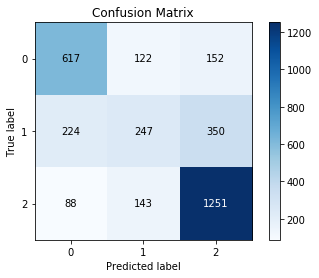

In [143]:
skplt.metrics.plot_confusion_matrix(y_test, ypred, normalize=False)

In [134]:
import seaborn as sn

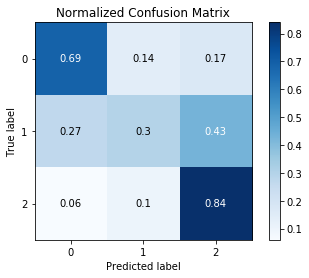

In [142]:
import scikitplot as skplt 
skplt.metrics.plot_confusion_matrix(y_test, ypred, normalize=True)

In [ ]:
# too many misclassification errors for draw matches

# try XGboost with engineered features

In [201]:
df_cleaned = df.dropna(axis = 0, how ='any') 

In [202]:
df_cleaned["diffHaltimeGoals"] = abs(df_cleaned["HTAG"]-df_cleaned["HTHG"])
df_cleaned["diffShots"] = abs(df_cleaned["AS"]-df_cleaned["HS"])
df_cleaned["diffShotsOnTarget"] =  abs(df_cleaned["AST"]-df_cleaned["HST"])
df_cleaned["diffCorners"] =  abs(df_cleaned["AC"]-df_cleaned["HC"])

df_cleaned["diffFouls"] =  abs(df_cleaned["AF"]-df_cleaned["HF"])
df_cleaned["diffYcards"] =  abs(df_cleaned["AY"]-df_cleaned["HY"])
df_cleaned["diffRCards"] =  abs(df_cleaned["AR"]-df_cleaned["AR"])


/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [203]:
df_cleaned['HomeAwayteam']=df_cleaned['HomeTeam'] + "-X-"+ df_cleaned['AwayTeam']

/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [204]:
X= df_cleaned
X["AwayTeamEnc"] = le.fit_transform(X["AwayTeam"].astype(str))
X["HomeTeamEnc"] = le.fit_transform(X["HomeTeam"].astype(str))
X["leagueEnc"] = le.fit_transform(X["league"].astype(str))
X["HomeAwayteamEnc"] = le.fit_transform(X["HomeAwayteam"].astype(str))
X= X.drop("AwayTeam", axis=1)
X=X.drop("HomeTeam", axis=1)
X= X.drop("league", axis=1)
X= X.drop("FTR", axis=1)
X= X.drop("Date", axis=1)
X= X.drop("HomeAwayteam", axis=1)

/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [205]:
y = le.fit_transform(df_cleaned.FTR)
classlabels = le.classes_

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, yres, random_state=42, stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((9582, 25), (9582,), (3194, 25), (3194,))

In [207]:


finalparams = {
    'objective': 'multi:softmax',
    'max_depth': 8,
    'learning_rate': 0.5,
    'n_estimators': 5,
    'n_estimators' :1000,
    'min_child_weight':1,
    'n_jobs':1,
    'gamma':5,
}

In [208]:
clf = XGBClassifier(**params)

xgb_param = clf.get_xgb_params()
xgb_param['num_class'] = 3

In [209]:
bst = clf.fit(X_train, y_train, eval_metric='mlogloss')

In [210]:
y_test_pred = bst.predict(X_test)
y_test_pred

array([2, 1, 2, ..., 0, 2, 2])

In [211]:
print(classification_report(y_test, y_test_pred, target_names=classlabels))

              precision    recall  f1-score   support

           A       0.65      0.69      0.67       891
           D       0.46      0.32      0.38       821
           H       0.73      0.83      0.78      1482

    accuracy                           0.66      3194
   macro avg       0.61      0.61      0.61      3194
weighted avg       0.64      0.66      0.64      3194



# use draw result from anothr model into XGboost

##  stack Xgboost after Logistic reg model output 

In [186]:
import pickle
draw_pred_lr_model = pickle.load(open('lreg_model.sav', 'rb'))

In [173]:
df_cleaned = df.dropna(axis = 0, how ='any') 

In [174]:
df_cleaned["diffHaltimeGoals"] = abs(df_cleaned["HTAG"]-df_cleaned["HTHG"])
df_cleaned["diffShots"] = abs(df_cleaned["AS"]-df_cleaned["HS"])
df_cleaned["diffShotsOnTarget"] =  abs(df_cleaned["AST"]-df_cleaned["HST"])
df_cleaned["diffCorners"] =  abs(df_cleaned["AC"]-df_cleaned["HC"])

df_cleaned["diffFouls"] =  abs(df_cleaned["AF"]-df_cleaned["HF"])
df_cleaned["diffYcards"] =  abs(df_cleaned["AY"]-df_cleaned["HY"])
df_cleaned["diffRCards"] =  abs(df_cleaned["AR"]-df_cleaned["AR"])


/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [ ]:
df_cleaned['HomeAwayteam']=df_cleaned['HomeTeam'] + "-X-"+ df_cleaned['AwayTeam']

In [177]:
X= df_cleaned
X["AwayTeamEnc"] = le.fit_transform(X["AwayTeam"].astype(str))
X["HomeTeamEnc"] = le.fit_transform(X["HomeTeam"].astype(str))
X["leagueEnc"] = le.fit_transform(X["league"].astype(str))
X["HomeAwayteamEnc"] = le.fit_transform(X["HomeAwayteam"].astype(str))
X= X.drop("AwayTeam", axis=1)
X=X.drop("HomeTeam", axis=1)
X= X.drop("league", axis=1)
X= X.drop("FTR", axis=1)
X= X.drop("Date", axis=1)
X= X.drop("HomeAwayteam", axis=1)

/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

((9582, 10), (9582,), (3194, 10), (3194,))

In [178]:
selectf = ['AR', 'AY', 'HC', 'HR', 'HST', 'HTAG', 'HTHG', 'diffHaltimeGoals',
       'diffShots', 'diffShotsOnTarget']

In [191]:
X1= X[selectf]

In [192]:
X1.shape

(12776, 10)

In [193]:
predDr = draw_pred_lr_model.predict(X1)

In [194]:
X["drawpred"] = predDr
yres = le.fit_transform(df_cleaned.FTR)
classlabels = le.classes_

/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, yres, random_state=42, stratify=yres)

X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((9582, 11), (9582,), (3194, 11), (3194,))

In [196]:


finalparams = {
    'objective': 'multi:softmax',
    'max_depth': 8,
    'learning_rate': 0.5,
    'n_estimators': 5,
    'n_estimators' :1000,
    'min_child_weight':1,
    'n_jobs':1,
    'gamma':5,
}

In [197]:
clf = XGBClassifier(**params)

xgb_param = clf.get_xgb_params()
xgb_param['num_class'] = 3

In [198]:
bst = clf.fit(X_train, y_train, eval_metric='mlogloss')



In [199]:
y_test_pred = bst.predict(X_test)
y_test_pred


array([2, 1, 2, ..., 0, 2, 2])

In [200]:
print(classification_report(y_test, y_test_pred, target_names=classlabels))

              precision    recall  f1-score   support

           A       0.68      0.63      0.65       891
           D       0.45      0.36      0.40       821
           H       0.71      0.83      0.76      1482

    accuracy                           0.65      3194
   macro avg       0.62      0.60      0.61      3194
weighted avg       0.64      0.65      0.64      3194



## stack Xgboost after Rforest model output

In [212]:
import pickle
draw_pred_rfmodel = pickle.load(open('rf_model2.sav', 'rb'))

In [213]:
df_cleaned = df.dropna(axis = 0, how ='any') 

In [214]:
df_cleaned["diffHaltimeGoals"] = abs(df_cleaned["HTAG"]-df_cleaned["HTHG"])
df_cleaned["diffShots"] = abs(df_cleaned["AS"]-df_cleaned["HS"])
df_cleaned["diffShotsOnTarget"] =  abs(df_cleaned["AST"]-df_cleaned["HST"])
df_cleaned["diffCorners"] =  abs(df_cleaned["AC"]-df_cleaned["HC"])

df_cleaned["diffFouls"] =  abs(df_cleaned["AF"]-df_cleaned["HF"])
df_cleaned["diffYcards"] =  abs(df_cleaned["AY"]-df_cleaned["HY"])
df_cleaned["diffRCards"] =  abs(df_cleaned["AR"]-df_cleaned["AR"])

/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [215]:
df_cleaned['HomeAwayteam']=df_cleaned['HomeTeam'] + "-X-"+ df_cleaned['AwayTeam']
X= df_cleaned
X["AwayTeamEnc"] = le.fit_transform(X["AwayTeam"].astype(str))
X["HomeTeamEnc"] = le.fit_transform(X["HomeTeam"].astype(str))
X["leagueEnc"] = le.fit_transform(X["league"].astype(str))
X["HomeAwayteamEnc"] = le.fit_transform(X["HomeAwayteam"].astype(str))
X= X.drop("AwayTeam", axis=1)
X=X.drop("HomeTeam", axis=1)
X= X.drop("league", axis=1)
X= X.drop("FTR", axis=1)
X= X.drop("Date", axis=1)
X= X.drop("HomeAwayteam", axis=1)

/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/srimugunthan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [216]:
selectf = ['AR', 'AY', 'HC', 'HR', 'HST', 'HTAG', 'HTHG', 'diffHaltimeGoals',
       'diffShots', 'diffShotsOnTarget']

In [217]:
X1= X[selectf]

In [218]:
predDr = draw_pred_rfmodel.predict(X1)

In [219]:
X["drawpred"] = predDr
yres = le.fit_transform(df_cleaned.FTR)
classlabels = le.classes_

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, yres, random_state=42, stratify=yres)

X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((9582, 26), (9582,), (3194, 26), (3194,))

In [225]:

finalparams = {
    'objective': 'multi:softmax',
    'max_depth': 8,
    'learning_rate': 0.5,
    'n_estimators': 5,
    'n_estimators' :1000,
    'min_child_weight':1,
    'n_jobs':1,
    'gamma':5,
}


clf = XGBClassifier(**finalparams)

xgb_param = clf.get_xgb_params()
xgb_param['num_class'] = 3



In [226]:
bst = clf.fit(X_train, y_train, eval_metric='mlogloss')

In [227]:
y_test_pred = bst.predict(X_test)

In [228]:
print(classification_report(y_test, y_test_pred, target_names=classlabels))

              precision    recall  f1-score   support

           A       0.79      0.75      0.77       891
           D       0.91      0.79      0.85       821
           H       0.81      0.90      0.85      1482

    accuracy                           0.83      3194
   macro avg       0.84      0.81      0.82      3194
weighted avg       0.83      0.83      0.83      3194



In [230]:
import pickle
filename = 'xgbmodel.sav'
pickle.dump(clf, open(filename, 'wb'))

In [232]:
import pickle
xgbmodel = pickle.load(open('xgbmodel.sav', 'rb'))

In [234]:
y_test_pred2 = xgbmodel.predict(X_test)

In [235]:
print(classification_report(y_test, y_test_pred2, target_names=classlabels))

              precision    recall  f1-score   support

           A       0.79      0.75      0.77       891
           D       0.91      0.79      0.85       821
           H       0.81      0.90      0.85      1482

    accuracy                           0.83      3194
   macro avg       0.84      0.81      0.82      3194
weighted avg       0.83      0.83      0.83      3194



In [236]:
X_test.shape

(3194, 26)

In [237]:
X_test.head()

,AC,AF,AR,AS,AST,AY,HC,HF,HR,HS,...,diffShotsOnTarget,diffCorners,diffFouls,diffYcards,diffRCards,AwayTeamEnc,HomeTeamEnc,leagueEnc,HomeAwayteamEnc,drawpred
4599,3.0,13.0,0.0,6.0,3.0,0.0,6.0,17.0,0.0,10.0,...,2.0,3.0,4.0,5.0,0.0,48,144,1,3777,0
2528,3.0,18.0,1.0,3.0,0.0,1.0,9.0,22.0,0.0,13.0,...,2.0,6.0,4.0,3.0,0.0,3,108,1,2795,1
9610,5.0,14.0,0.0,12.0,2.0,2.0,9.0,11.0,0.0,19.0,...,1.0,4.0,3.0,1.0,0.0,40,137,3,3579,1
2694,7.0,13.0,0.0,17.0,5.0,1.0,5.0,12.0,0.0,14.0,...,3.0,2.0,1.0,1.0,0.0,126,129,1,3370,0
4655,3.0,16.0,0.0,7.0,2.0,5.0,0.0,14.0,0.0,14.0,...,5.0,3.0,2.0,4.0,0.0,59,9,1,233,0


In [238]:
X_test.columns

Index(['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'HC', 'HF', 'HR', 'HS', 'HST',
       'HTAG', 'HTHG', 'HY', 'diffHaltimeGoals', 'diffShots',
       'diffShotsOnTarget', 'diffCorners', 'diffFouls', 'diffYcards',
       'diffRCards', 'AwayTeamEnc', 'HomeTeamEnc', 'leagueEnc',
       'HomeAwayteamEnc', 'drawpred'],
      dtype='object')

In [239]:
classlabels

array(['A', 'D', 'H'], dtype=object)